In [2]:
import openpmd_api
import seaborn as sns
from os.path import join
import matplotlib.pylab as plt
import matplotlib as mpl
import numpy as np
import skimage
import fdrot

In [3]:
base_path = '/bigdata/hplsim/scratch/ordyna35/runs/'
sim = 'FoilLCT_3D_03'
inner_path = 'simOutput/h5/'
section_spc = 'simData_%T.h5'

In [4]:
path = join(base_path, sim)
path = join(path, inner_path)
full_path = join(path, section_spc)

In [5]:

! ls $path

simData_0.h5	 simData_2250.h5  simData_3500.h5  simData_5000.h5
simData_1000.h5  simData_2500.h5  simData_3750.h5  simData_500.h5
simData_1250.h5  simData_250.h5   simData_4000.h5  simData_750.h5
simData_1500.h5  simData_2750.h5  simData_4250.h5
simData_1750.h5  simData_3000.h5  simData_4500.h5
simData_2000.h5  simData_3250.h5  simData_4750.h5


In [6]:

series = openpmd_api.Series(full_path, openpmd_api.Access_Type.read_only)

In [7]:
files = fdrot.sim_data.OpenPMDList(series, data_stored=['Bz','Bx', 'By', 'n_e'])

In [8]:
# test if attributes are set correctly
files.__dict__

{'fields_mapping': {'Bx': ('B', 'x'),
  'By': ('B', 'y'),
  'Bz': ('B', 'z'),
  'n_e': ('e_density', '\x0bScalar')},
 'series': <openPMD.Attributable with '11' attributes>,
 'single_time_step': 4.012152503219213e-18,
 '_ids': [0,
  250,
  500,
  750,
  1000,
  1250,
  1500,
  1750,
  2000,
  2250,
  2500,
  2750,
  3000,
  3250,
  3500,
  3750,
  4000,
  4250,
  4500,
  4750,
  5000],
 'grid': (2.083333295939834e-09, 2.083333295939834e-09, 2.083333295939834e-09),
 'sim_box_shape': (32, 400, 64),
 'data_stored': ['Bz', 'Bx', 'By', 'n_e'],
 'axis_order': {'z': 0, 'y': 1, 'x': 2}}

In [9]:
# create a gauss pulse
def gauss(x, sigma, mu):
    gauss = np.exp(-0.5 * ((x-mu)/sigma)**2)
    return gauss
def gauss_pulse(length, sigma):
    x = np.arange(length) + 0.5
    mu = length / 2
    gs = gauss(x, sigma, mu)
    gs = gs / np.sum(gs)
    return x, gs

3062

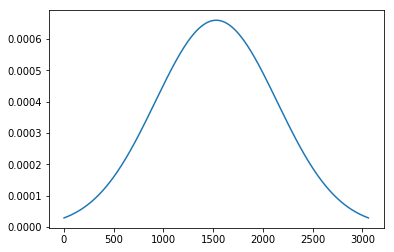

In [10]:
from scipy.constants import c
grid_step = files.grid[files.axis_order['x']]
sigma = (10e-15 *c / (grid_step)) /2.35
pulse_length_cells = 2.5*2*sigma
pulse_length_cells = int(round(pulse_length_cells))
x, y = gauss_pulse(pulse_length_cells, sigma)
plt.plot(x,y)
pulse = y
pulse_length_cells

In [11]:
inc_time = 4500 * files.single_time_step
sequence = fdrot.sim_sequence.seq_cells(start=0,
                             end=64,
                             inc_time=inc_time,
                             iter_step=250,
                             pulse_length_cells=1,
                             files=files,
                             propagation_axis='x')
sequence.number_of_steps

1

In [12]:
from scipy.constants import physical_constants

h = physical_constants['Planck constant in eV s'][0]
E = 6.5e3 # eV
wvl = h * c / E
'wavelength:', wvl, 'm'

('wavelength:', 1.9074491905570662e-10, 'm')

In [13]:
rotated = sequence.rotation_3d_perp(pulse=np.ones(1, dtype=np.float32), second_axis_output='y', wavelength=wvl, global_cut_output_first=None, global_cut_output_second=(90,186))

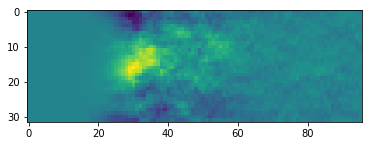

In [14]:
plt.imshow(rotated)

In [15]:
%matplotlib inline

In [42]:
product.shape

(32, 400, 64)

In [16]:
product = files.open(4500, 'Bx') * files.open(4500, 'n_e')

product_slice_front = product[:,90:186,0] # 90:170
product_slice_top = product[0, 90:186, :]
product_slice_right = product[:,185, :]
all_sides = [product_slice_front, product_slice_right, product_slice_top]
v_max  = 0
for side in all_sides:
    val = max([abs(np.min(side)), abs(np.max(side))])
    if val > v_max:
        v_max = val
v_max *=0.25
norm = mpl.colors.Normalize(vmin=-v_max, vmax=v_max)

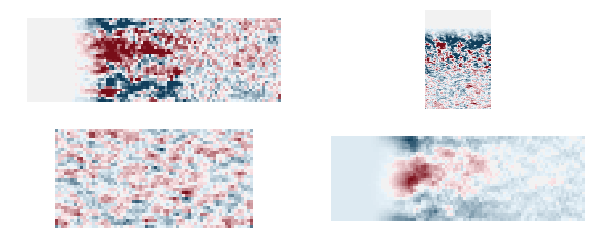

In [17]:
f, ax = plt.subplots(2,2, figsize=(10,4))
plt.axis('off')
cmap = sns.diverging_palette(240, 10, s=90, l=25, n=250 ,
                                          center = 'light',
                                          as_cmap=True)
#v_max = max([abs(np.min(product_slice)), abs(np.max(product_slice))])
img_front = ax[0][0].imshow(product_slice_front, cmap=cmap, norm=norm )
img_top = ax[0][1].imshow(product_slice_top, cmap=cmap, norm=norm )
img_right = ax[1][0].imshow(product_slice_right, cmap=cmap, norm=norm )
ing_rot = ax[1][1].imshow(rotated, cmap=cmap )
for axis in ax.reshape(4):
    axis.set_axis_off()
#f.colorbar(ax.images[0], ax=ax)
#f.savefig("left.png",  )

In [29]:
img_front.write_png('front.png')
img_right.write_png('right.png')
img_top.write_png('top.png')
ing_rot.write_png('rot.png')

In [39]:
images =[('front',(10,30) ), ('right',(10, 20) ), ('top', (30, 20)), ('rot', (10,30))]
images_resized = [None] * 4
for ii, (name, shape) in enumerate(images):
    image = skimage.io.imread(name + ".png")
    images_resized[ii]  = skimage.transform.resize(image, shape)

/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifac

In [40]:
images_resized[0].shape

(10, 30, 4)

In [41]:
images_resized[0][0,:,:] = images_resized[2][:,0,:]
images_resized[2][-1,:,:] = images_resized[1][0,:,:]
images_resized[0][:,-1,:] = images_resized[1][:,0,:]
for ii, (name, shape) in enumerate(images):
    skimage.io.imsave(name + '_scaled.png', images_resized[ii])

/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))
/home/ordyna35/anaconda3/envs/fdrot/lib/python3.6/site-packages/skimage/util/dtype.py:141: UserWarning: Possible precision loss when converting from float64 to uint8
  .format(dtypeobj_in, dtypeobj_out))


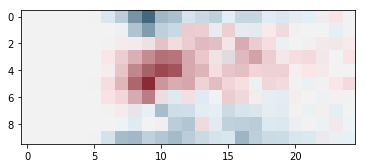

In [209]:
f, ax = plt.subplots(1)
ax.imshow(image_resized)
ax.images[0].write_png('rotation_scaled.png')

In [38]:
skimage.io.imsave?